<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
!pip install torchsummary

In [2]:
import random
import os
import time
import skimage.io
import torch

import numpy as np
import pandas as pd
from copy import deepcopy
from torchsummary import summary
from IPython.display import clear_output
from skimage.transform import resize, rescale
from sklearn.model_selection import train_test_split

from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data_utils

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [4]:
# Настройка случайных чисел
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Может уменьшить время выполнения программы
torch.backends.cudnn.deterministic = True

In [5]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [6]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()

images not found, donwloading...


--2021-12-26 10:43:32--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  862K 2m3s
    50K .......... .......... .......... .......... ..........  0% 1.67M 93s
   100K .......... .......... .......... .......... ..........  0%  104M 62s
   150K .......... .......... .......... .......... ..........  0% 82.1M 47s
   200K .......... .......... .......... .......... ..........  0% 1.71M 50s
   250K .......... .......... .......... .......... ..........  0% 85.2M 41s
   300K .......... .......... .......... .......... ..........  0% 78.9M 36s
   350K .......... .......... .......... .......... ..........  0% 62.9M 31s
   400K .......... ........

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2021-12-26 10:43:38--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2021-12-26 10:43:38--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0% 1.37M 10s
    50K .......... .......... .......... .......... ..........  0% 2.80M 8s
   100K .......... .......... .......... .......... ..........  1% 54.9M 5s
   150K .......... .......... .......... .

done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [7]:
batch_size = 32

train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=False)
print("Data train shape: {}".format(train_photos.shape))
print("Data valid shape: {}".format(val_photos.shape))

data_tr = torch.utils.data.DataLoader(train_photos, batch_size=batch_size)
data_val = torch.utils.data.DataLoader(val_photos, batch_size=batch_size)

Data train shape: (11828, 64, 64, 3)
Data valid shape: (1315, 64, 64, 3)


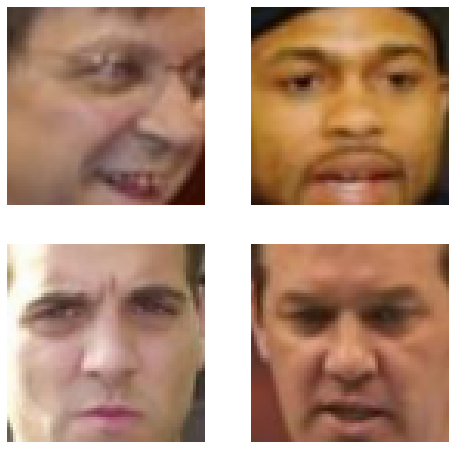

In [8]:
# Вывести несколько изображений
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_photos), size=(1,)).item()
    img = train_photos[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так


In [9]:
dim_code = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

### Complex Autoencoder

Использован BatchNorm2d

In [10]:
class Autoencoder_complex(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
          nn.Conv2d(64, 256, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, 128, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128, 16, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(16),
          nn.ReLU()
          )
      
        self.fc = nn.Sequential(
          nn.Linear(16 * 64 * 3, dim_code),
          nn.ReLU()
        )
        self.unfc = nn.Sequential(
          nn.Linear(dim_code, 16 * 64 * 3),
          nn.ReLU()
        )
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(16, 128, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.ConvTranspose2d(128, 256, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.ConvTranspose2d(256, 64, kernel_size=7, stride=1, padding=3),
          )
              
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        latent_code = self.fc(x)
        x = self.unfc(latent_code).view(-1, 16, dim_code, 3)
        reconstruction = self.decoder(x)
        
        return reconstruction, latent_code

autoencoder_complex = Autoencoder_complex().to(DEVICE)
summary(autoencoder_complex.cuda(), (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 256, 64, 3]         803,072
       BatchNorm2d-2           [-1, 256, 64, 3]             512
              ReLU-3           [-1, 256, 64, 3]               0
            Conv2d-4           [-1, 128, 64, 3]       1,605,760
       BatchNorm2d-5           [-1, 128, 64, 3]             256
              ReLU-6           [-1, 128, 64, 3]               0
            Conv2d-7            [-1, 16, 64, 3]         100,368
       BatchNorm2d-8            [-1, 16, 64, 3]              32
              ReLU-9            [-1, 16, 64, 3]               0
          Flatten-10                 [-1, 3072]               0
           Linear-11                   [-1, 64]         196,672
             ReLU-12                   [-1, 64]               0
           Linear-13                 [-1, 3072]         199,680
             ReLU-14                 [-

### Simple Autoencoder

In [11]:
from copy import deepcopy
from torchsummary import summary

class Autoencoder_simple(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU()
        )
      
        self.fc = nn.Sequential(
            nn.Linear(16 * 64 * 3, dim_code),
            nn.ReLU()
        )

        self.unfc = nn.Sequential(
            nn.Linear(dim_code, 16 * 64 * 3),
            nn.ReLU()
        )

        self.decoder =  nn.Sequential(
            nn.ConvTranspose2d(16, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=3, padding=1, stride=1),
        )
          
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        latent_code = self.fc(x)
        x = self.unfc(latent_code).view(-1, 16, dim_code, 3)
        reconstruction = self.decoder(x)
        
        return reconstruction, latent_code

autoencoder_simple = Autoencoder_simple().to(DEVICE)
summary(autoencoder_simple.cuda(), (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 256, 64, 3]         147,712
              ReLU-2           [-1, 256, 64, 3]               0
            Conv2d-3           [-1, 256, 64, 3]         590,080
              ReLU-4           [-1, 256, 64, 3]               0
            Conv2d-5           [-1, 128, 64, 3]         295,040
              ReLU-6           [-1, 128, 64, 3]               0
            Conv2d-7           [-1, 128, 64, 3]         147,584
              ReLU-8           [-1, 128, 64, 3]               0
            Conv2d-9            [-1, 16, 64, 3]          18,448
             ReLU-10            [-1, 16, 64, 3]               0
          Flatten-11                 [-1, 3072]               0
           Linear-12                   [-1, 64]         196,672
             ReLU-13                   [-1, 64]               0
           Linear-14                 [-

In [12]:
!nvidia-smi

Sun Dec 26 10:44:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |    973MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

### Train Complex Autoencoder

In [13]:
criterion = F.mse_loss

autoencoder_complex = Autoencoder_complex().to(DEVICE)

optimizer = torch.optim.AdamW(autoencoder_complex.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

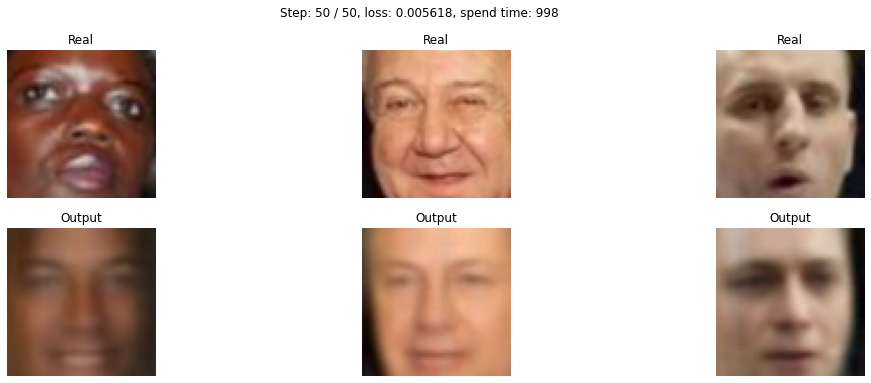

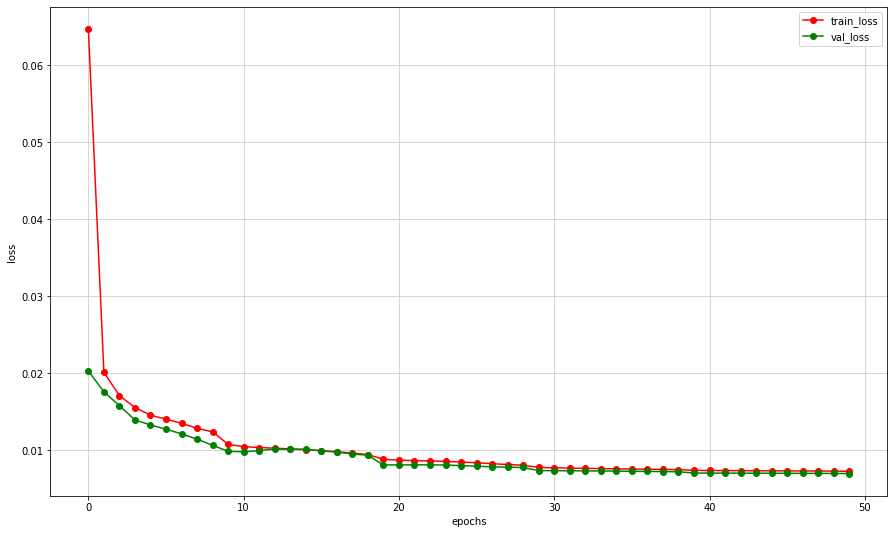

Wasted time: 998


In [14]:
n_epochs = 50
train_losses = []
val_losses = []
latents_complex = torch.Tensor()
truth_complex = torch.Tensor()
pred_complex = torch.Tensor()
start_time = time.time()

for epoch in tqdm(range(n_epochs)):
    autoencoder_complex.train()
    scheduler.step()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(data_tr):
        optimizer.zero_grad()
        reconstructed, latent_image = autoencoder_complex(X_batch.to(DEVICE))
        loss = criterion(reconstructed, X_batch.to(DEVICE))
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder_complex.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in data_val:
            reconstructed, latent_image = autoencoder_complex(X_batch.to(DEVICE))
            loss = criterion(reconstructed, X_batch.to(DEVICE))
            val_losses_per_epoch.append(loss.item())
            if epoch == n_epochs - 1:
                truth_complex = torch.cat((truth_complex, X_batch), 0)
                latents_complex = torch.cat((latents_complex, latent_image.to('cpu')), 0)
                pred_complex = torch.cat((pred_complex, reconstructed.to('cpu')), 0)

    val_losses.append(np.mean(val_losses_per_epoch))

    # Visualize tools
    plt.figure(figsize=(18, 6))
    clear_output(wait=True)
    for k in range(3):
        plt.subplot(2, 3, k+1)
        plt.imshow(X_batch[k].cpu())
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 3, k+4)
        plt.imshow(reconstructed[k].cpu())
        plt.title('Output')
        plt.axis('off')
    plt.suptitle('Step: %d / %d, loss: %f, spend time: %.0f' % (epoch+1, 
                                                                n_epochs, 
                                                                loss.item(), 
                                                                time.time()-start_time))
    plt.show()

    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, 'r-o', label="train_loss")
    plt.plot(val_losses, 'g-o', label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.grid(color='0.8')
    plt.show()

print("Wasted time: {:.0f}".format(time.time()-start_time))

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

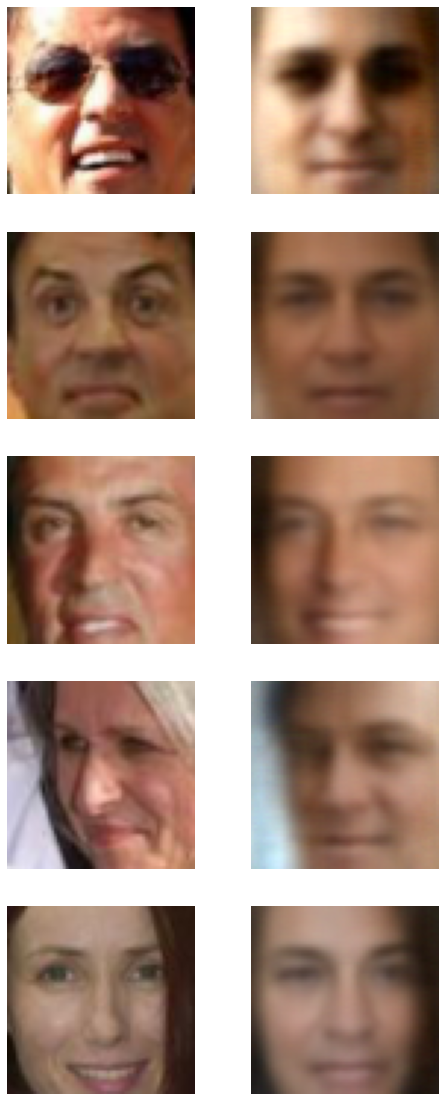

In [15]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(truth_complex[:5], pred_complex[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(res)

### Train Simple Autoencoder

In [16]:
criterion = F.mse_loss

autoencoder_simple = Autoencoder_simple().to(DEVICE)

optimizer = torch.optim.AdamW(autoencoder_simple.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

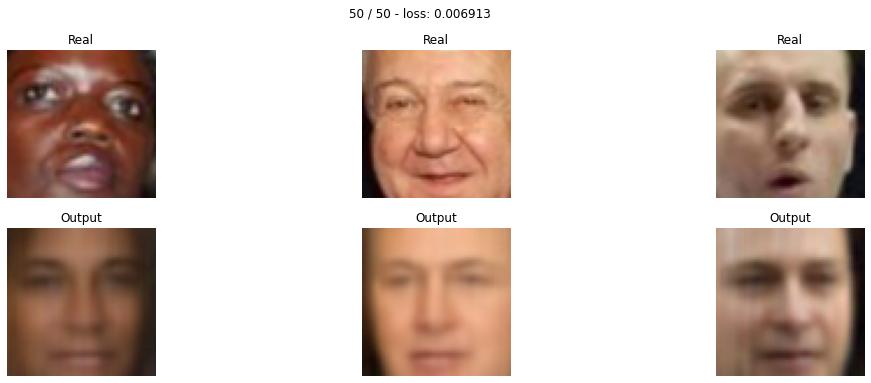

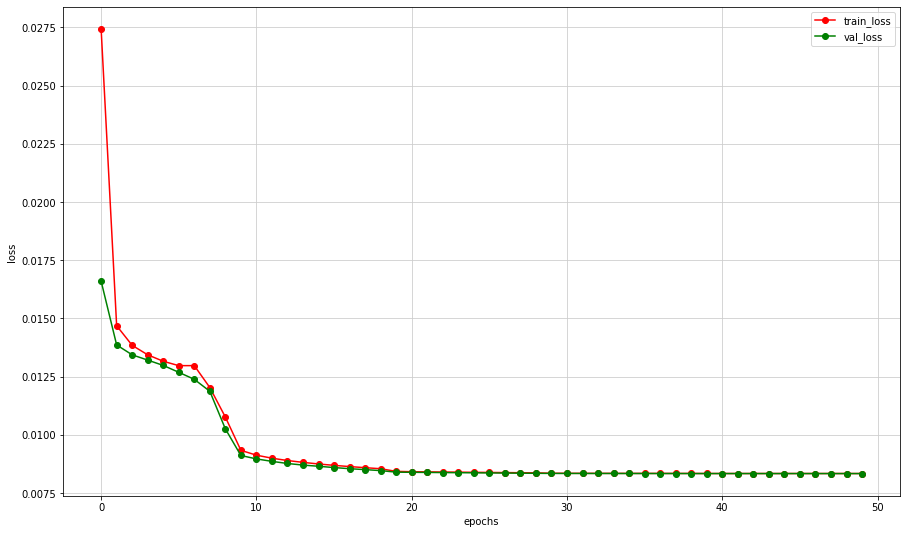

Wasted time: 459


In [17]:
n_epochs = 50
train_losses = []
val_losses = []
latents_simple = torch.Tensor()
truth_simple = torch.Tensor()
pred_simple = torch.Tensor()
start_time = time.time()

for epoch in tqdm(range(n_epochs)):
    autoencoder_simple.train()
    scheduler.step()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(data_tr):
        optimizer.zero_grad()
        reconstructed, latent_image = autoencoder_simple(X_batch.to(DEVICE))
        loss = criterion(reconstructed, X_batch.to(DEVICE))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder_simple.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in data_val:
            reconstructed, latent_image = autoencoder_simple(X_batch.to(DEVICE))
            loss = criterion(reconstructed, X_batch.to(DEVICE))
            val_losses_per_epoch.append(loss.item())
            if epoch == n_epochs - 1:
                truth_simple = torch.cat((truth_simple, X_batch), 0)
                latents_simple = torch.cat((latents_simple, latent_image.to('cpu')), 0)
                pred_simple = torch.cat((pred_simple, reconstructed.to('cpu')), 0)

    val_losses.append(np.mean(val_losses_per_epoch))

    # Visualize tools
    plt.figure(figsize=(18, 6))
    clear_output(wait=True)
    for k in range(3):
        plt.subplot(2, 3, k+1)
        plt.imshow(X_batch[k].cpu())
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 3, k+4)
        plt.imshow(reconstructed[k].cpu())
        plt.title('Output')
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, loss.item()))
    plt.show()

    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, 'r-o', label="train_loss")
    plt.plot(val_losses, 'g-o', label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.grid(color='0.8')
    plt.show()

print("Wasted time: {:.0f}".format(time.time()-start_time))

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

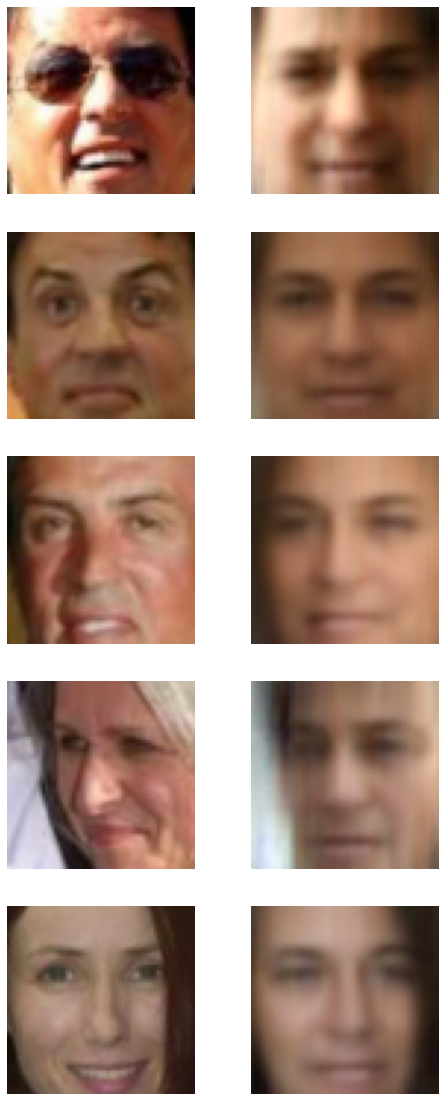

In [18]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(truth_simple[:5], pred_simple[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.axis('off')
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.axis('off')
    plt.imshow(res)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

### Sampling Complex Autoencoder

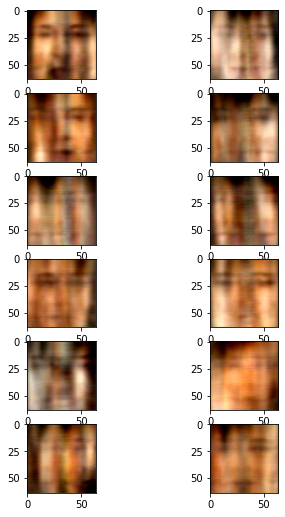

In [19]:
# сгенерируем 25 рандомных векторов размера latent_space
# z = np.random.randn(25, dim_code)
mu = torch.mean(latents_complex, (0, 1)).item()
sigma = torch.std(latents_complex, (0, 1)).item()
z = np.array([sigma * np.random.normal(0, 1, dim_code) + mu for i in range(25)])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
output = autoencoder_complex.decoder(
    autoencoder_complex.unfc(torch.FloatTensor(z).to(device)).view(-1, 16, 64, 3)
    )

plt.figure(figsize=(6, 18))
for i in range(12):
    plt.subplot(12, 2, i + 1)
    plt.imshow(output[i].cpu().detach().numpy())

plt.show()

### Sampling Simple Autoencoder

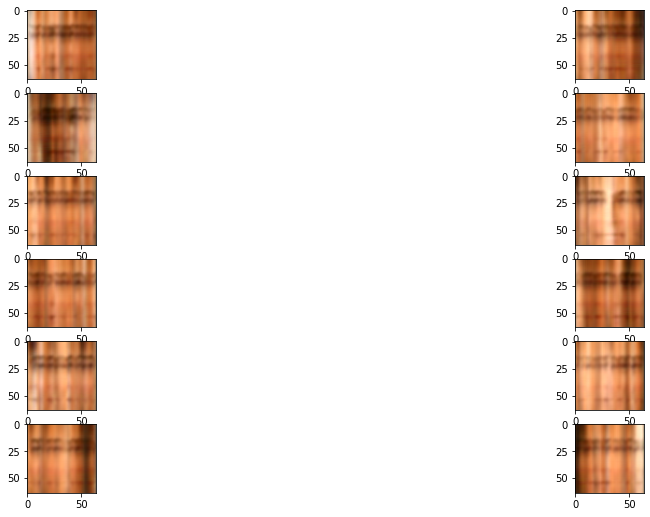

In [20]:
mu = torch.mean(latents_simple, (0, 1)).item()
sigma = torch.std(latents_simple, (0, 1)).item()
z = np.array([sigma * np.random.normal(0, 1, dim_code) + mu for i in range(25)])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
output = autoencoder_simple.decoder(
    autoencoder_simple.unfc(torch.FloatTensor(z).to(device)).view(-1, 16, 64, 3)
    )
plt.figure(figsize=(18, 18))
for i in range(12):
    plt.subplot(12, 2, i + 1)
    plt.imshow(output[i].cpu().detach().numpy())

plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [21]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

### Simple Autoencoder

In [22]:
def to_latent_mean(x):
    x = autoencoder_simple.encoder(x)
    x = autoencoder_simple.flatten(x)
    x = autoencoder_simple.fc(x).to('cpu')
    z = torch.mean(x)
    return x, z

In [23]:
def change(latent_target_mean, latent_orig_mean, latent_orig):
    vector = latent_target_mean - latent_orig_mean
    changed_latent_orig = latent_orig + vector
    x = autoencoder_simple.unfc(changed_latent_orig.to(device)).view(-1, 16, 64, 3)
    changed_image = autoencoder_simple.decoder(x)
    return changed_image

In [24]:
def show_images(x, y):
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        plt.axis("off")
        plt.imshow(x[i].cpu().detach().numpy())

        plt.subplot(2, 6, i + 7)
        plt.axis("off")
        plt.imshow(y[i].cpu().detach().numpy())
    plt.show();

In [25]:
smile_idx = attrs.sort_values(['Smiling']).tail(15).index.tolist()
sad_idx = attrs.sort_values(['Smiling']).head(15).index.tolist()
smile_data = torch.FloatTensor(data[smile_idx]).to(device)
sad_data = torch.FloatTensor(data[sad_idx]).to(device)

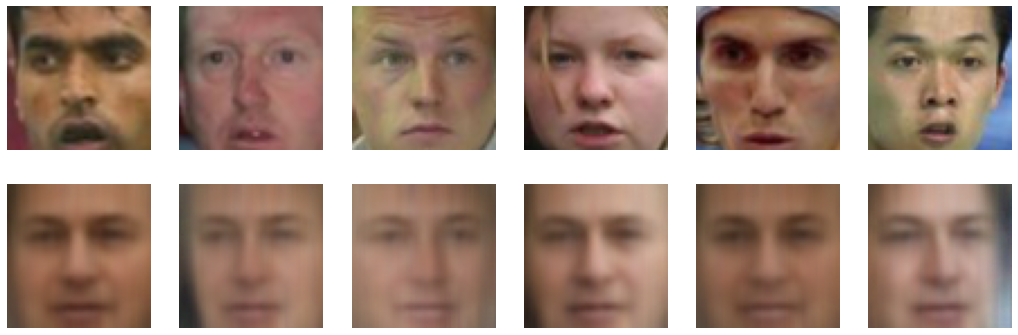

In [26]:
latent_smile, latent_smile_mean = to_latent_mean(smile_data)
latent_sad, latent_sad_mean = to_latent_mean(sad_data)

changed_data = change(latent_smile_mean, latent_sad_mean, latent_sad)
show_images(sad_data, changed_data)

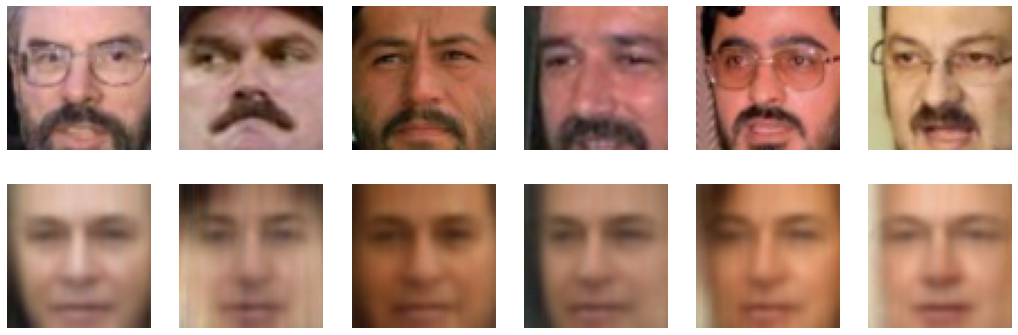

In [27]:
attrib = 'No Beard'


targ_idx = attrs.sort_values([attrib]).tail(15).index.tolist()
orig_idx = attrs.sort_values([attrib]).head(15).index.tolist()
targ_data = torch.FloatTensor(data[targ_idx]).to(device)
orig_data = torch.FloatTensor(data[orig_idx]).to(device)

latent_targ, latent_targ_mean = to_latent_mean(targ_data)
latent_orig, latent_orig_mean = to_latent_mean(orig_data)

changed_data = change(latent_targ_mean, latent_orig_mean, latent_orig)

show_images(orig_data, changed_data)

### Complex Autoencoder

In [28]:
def to_latent_mean(x):
    x = autoencoder_complex.encoder(x)
    x = autoencoder_complex.flatten(x)
    x = autoencoder_complex.fc(x).to('cpu')
    z = torch.mean(x)
    return x, z

In [29]:
def change(latent_target_mean, latent_orig_mean, latent_orig):
    vector = latent_target_mean - latent_orig_mean
    changed_latent_orig = latent_orig + vector
    x = autoencoder_complex.unfc(changed_latent_orig.to(device)).view(-1, 16, 64, 3)
    changed_image = autoencoder_complex.decoder(x)
    return changed_image

In [30]:
def show_images(x, y):
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        plt.axis("off")
        plt.imshow(x[i].cpu().detach().numpy())

        plt.subplot(2, 6, i + 7)
        plt.axis("off")
        plt.imshow(y[i].cpu().detach().numpy())
    plt.show();

In [31]:
smile_idx = attrs.sort_values(['Smiling']).tail(15).index.tolist()
sad_idx = attrs.sort_values(['Smiling']).head(15).index.tolist()
smile_data = torch.FloatTensor(data[smile_idx]).to(device)
sad_data = torch.FloatTensor(data[sad_idx]).to(device)

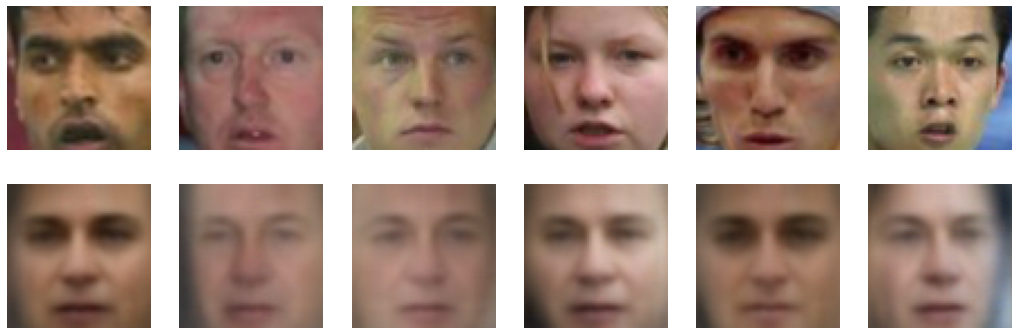

In [32]:
latent_smile, latent_smile_mean = to_latent_mean(smile_data)
latent_sad, latent_sad_mean = to_latent_mean(sad_data)

changed_data = change(latent_smile_mean, latent_sad_mean, latent_sad)
show_images(sad_data, changed_data)

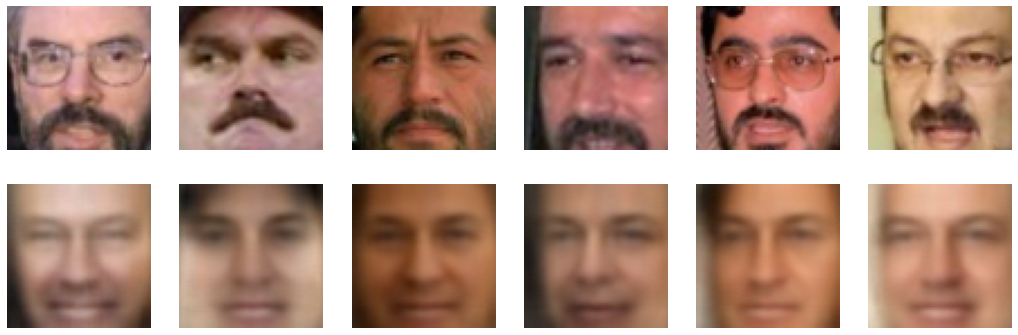

In [33]:
attrib = 'No Beard'


targ_idx = attrs.sort_values([attrib]).tail(15).index.tolist()
orig_idx = attrs.sort_values([attrib]).head(15).index.tolist()
targ_data = torch.FloatTensor(data[targ_idx]).to(device)
orig_data = torch.FloatTensor(data[orig_idx]).to(device)

latent_targ, latent_targ_mean = to_latent_mean(targ_data)
latent_orig, latent_orig_mean = to_latent_mean(orig_data)

changed_data = change(latent_targ_mean, latent_orig_mean, latent_orig)

show_images(orig_data, changed_data)

Выводы по первой части
1) Обе модели не супер хорошо восстанавливают лица. Возможно стоит использовать более усложненную модель. Например, нечто среднее между двумя рассмотреными
2) Разбавление шумами из нормального распределения латентного слоя внутри каждой модели не очень хорошо восстанавливается декодером. Думаю, что это как некоторое следствие из предыдущего пункта
3) Аналогично с добавлением улыбок и искуственным бритьем лиц

### Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [34]:
batch_size = 32
features = 8
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, 
                               transform=transforms.ToTensor(), 
                               download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', 
                              train=False, transform=transforms.ToTensor(), 
                              download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [35]:
flat_size = features * 28 * 28

In [36]:
class VAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, features, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(features),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(flat_size, 512),
          nn.ReLU(),
          nn.Linear(512, features * 2)
          )
        
        self.decoder = nn.Sequential(
          nn.Linear(features, 512),
          nn.ReLU(),
          nn.Linear(512, flat_size),
          nn.ReLU(),
          nn.Unflatten(1, (features, 28, 28)),
          nn.ConvTranspose2d(features, 64, kernel_size=5, stride=1, padding=2),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 1, kernel_size=5, stride=1, padding=2),
          )

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
        new_x = self.encoder(x).view(x.shape[0], 2, -1)
        mu = new_x[:, 0, :]
        logsigma = new_x[:, 1, :]
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [37]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных 
    представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции 
    (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [38]:
criterion = loss_vae

autoencoder = VAE().to(DEVICE)

optimizer = torch.optim.Adam(autoencoder.parameters())

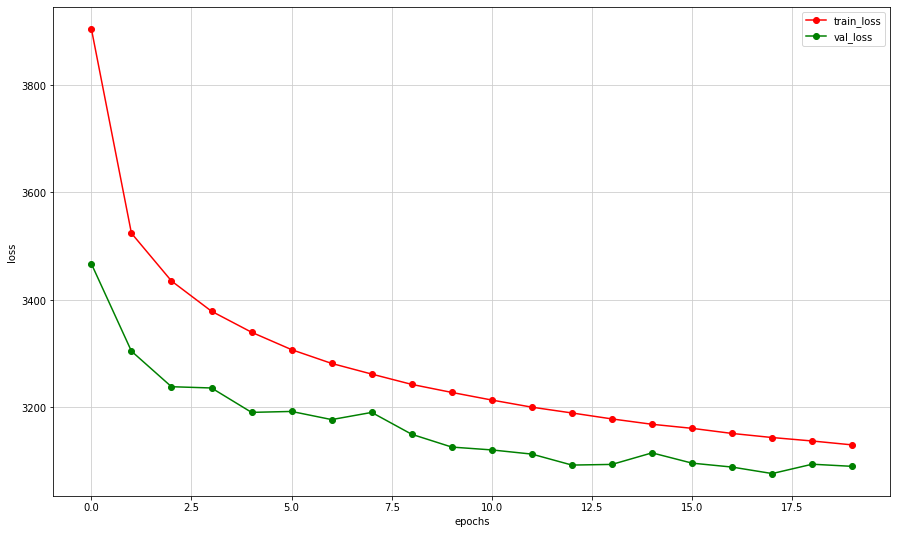

In [39]:
# <обучите модель на датасете MNIST>
n_epochs = 20
train_losses = []
test_losses = []
mus = torch.Tensor()
labels = torch.Tensor()

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch, label in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(DEVICE))
        loss = criterion(batch.to(DEVICE).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    test_losses_per_epoch = []
    with torch.no_grad():
        for batch, label in test_loader:
            reconstruction, mu, logsigma = autoencoder(batch.to(DEVICE))
            loss = criterion(batch.to(DEVICE).float(), mu, logsigma, reconstruction)
            test_losses_per_epoch.append(loss.item())
            if epoch == n_epochs - 1:
                mus = torch.cat((mus, mu.to('cpu')), 0)
                labels = torch.cat((labels, label), dim=0)

    test_losses.append(np.mean(test_losses_per_epoch))

    # Visualize tools
    clear_output(wait=True)

    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, 'r-o', label="train_loss")
    plt.plot(test_losses, 'g-o', label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.grid(color='0.8')
    plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

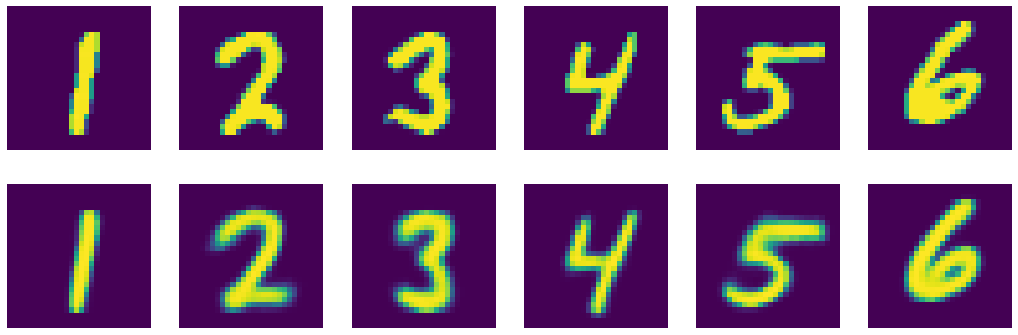

In [40]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.axis("off")
    plt.imshow(batch[i][0].cpu().detach().numpy())
    plt.subplot(2, 6, i + 7)
    plt.axis("off")
    plt.imshow(reconstruction[i][0].cpu().detach().numpy())
plt.show();

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

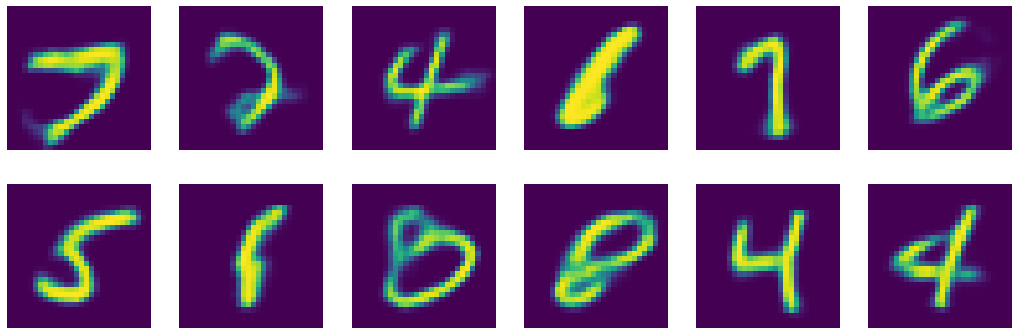

In [41]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(12)])
output = autoencoder.decode(torch.FloatTensor(z).to(device))

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.axis("off")
    plt.imshow(output[i][0].cpu().detach().numpy())
    plt.subplot(2, 6, i + 7)
    plt.axis("off")
    plt.imshow(output[i + 6][0].cpu().detach().numpy())
plt.show();

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

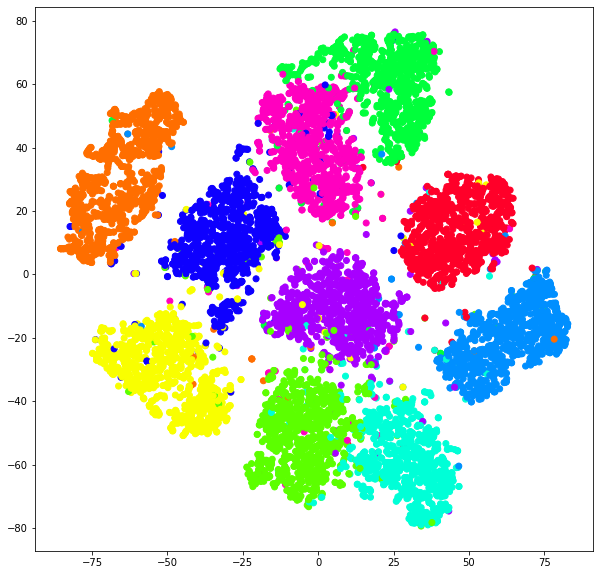

In [42]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

from sklearn.manifold import TSNE

mus_embedded = torch.from_numpy(TSNE(n_components=2).fit_transform(mus))
labels = labels.view(-1, 1)
mus_emb = torch.cat((mus_embedded, labels), dim = 1)

plt.figure(figsize=(10, 10))
plt.scatter(mus_emb[:, 0], mus_emb[:, 1], c=mus_emb[:, 2], cmap='gist_rainbow')

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [43]:
use_cuda = True
batch_size = 32
latent_size = 20 

In [44]:
# Было не просто подобрать архитектуру по картинкеи объяснениям. 
# Вроде получилось похоже на то, что требовалось
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): 
        inputs = torch.cat([x, c], 1)
        h1 = self.relu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def gaussian_sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std) + mu
        else:
            return mu

    def decode(self, z, c):
        inputs = torch.cat([z, c], 1) 
        h3 = self.relu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 28*28), c)
        z = self.gaussian_sampler(mu, logvar)
        return self.decode(z, c), mu, logvar

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [45]:
def to_var(x):
    x = Variable(x)
    if use_cuda:
        x = x.cuda()
    return x

def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return to_var(targets)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [46]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, labels) in enumerate(test_loader):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, 1, 28, 28)[:n]])

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [47]:
model = CVAE(28*28, latent_size, 10)
if use_cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.102610
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.007059
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.007114
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.006757
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.007231
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.007134
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.007018
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.006698
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.006750
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.006776
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.006737
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.006151
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.007021
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.006099
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.006268
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.007192
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.006854
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.005919
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.006312
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.006771
Train Epoch: 6 [0/60000 (

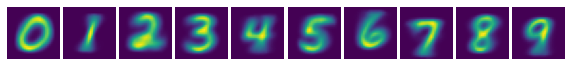

In [48]:
import matplotlib.gridspec as gridspec

c = torch.eye(10, 10) 
c = to_var(c)
z = to_var(torch.randn(10, latent_size))
samples = model.decode(z, c).data.cpu().numpy()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28))

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

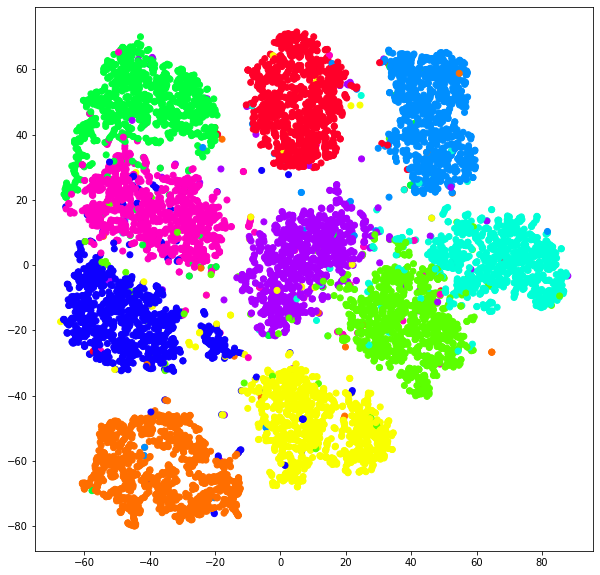

In [49]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

from sklearn.manifold import TSNE

mus_embedded = torch.from_numpy(TSNE(n_components=2).fit_transform(mus))
labels = labels.view(-1, 1)
mus_emb = torch.cat((mus_embedded, labels), dim = 1)

plt.figure(figsize=(10, 10))
plt.scatter(mus_emb[:, 0], mus_emb[:, 1], c=mus_emb[:, 2], cmap='gist_rainbow')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

При использовании модели CVAE классы разделяются лучше. Это отображается на картинке после использования TSNE.

Дополнительные задания интересны
Сделаю после финального проекта)

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>